In [1]:
%matplotlib inline
import os

import numpy as np
import xarray as xr

import ncar_jobqueue
from dask.distributed import Client

import matplotlib.pyplot as plt

import xpersist as xp
# Set up xperist cache
cache_dir = os.path.join(os.path.sep, 'glade', 'p', 'cgd', 'oce', 'projects', 'cesm2-marbl', 'xpersist_cache', '3d_fields')
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

import esmlab
import pop_tools

import utils
import climo_utils as cu
import ann_avg_utils as aau
UnitRegistry, _ = aau.get_pint_units()

%load_ext watermark
%watermark -a "Mike Levy" -d -iv -m -g -h

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/pooch/core.py:185: UserWarning: Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.
  warn(message)


xarray        0.15.0
pop_tools     0.0.post167
esmlab        2019.4.27.post55
xpersist      0.0.post25
numpy         1.18.1
ncar_jobqueue 2020.3.4
Mike Levy 2020-03-06 

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-693.21.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 72
interpreter: 64bit
host name  : casper21
Git hash   : 7dc42c00d4654757b572fc9995bbfcdded87675b


In [2]:
cluster = ncar_jobqueue.NCARCluster() #project='P93300606')
cluster.adapt(minimum_jobs=0, maximum_jobs=24)
client = Client(cluster)
client

Client Scheduler: tcp://128.117.181.227:39212 Dashboard: https://jupyterhub.ucar.edu/dav/user/mclong/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
nutrients = ['NO3', 'PO4', 'SiO3']

In [4]:
%%time

da_surf = dict()
ds = dict()
da_surf_obs = dict()
ds_obs = dict()

for variable in nutrients:
    # Read CESM and WOA data
    xp_func = xp.persist_ds(cu.read_CESM_var, name=f'{variable}', trust_cache=True)
    ds[variable] = xp_func(slice("1990-01-15", "2015-01-15"), variable, mean_dims=['member_id', 'time']) # 1990 - 2014, inclusive
    ds_obs[variable] = cu.read_obs(src='WOA', variable=variable)

    da_tmp = ds[variable][variable]
    da_surf[variable] = (da_tmp.isel(z_t=0).data * UnitRegistry[ds[variable][variable].attrs['units']])
    da_tmp = ds_obs[variable][variable]
    da_surf_obs[variable]=da_tmp.isel(z_t=0).data * UnitRegistry[da_tmp.attrs['units']] * (1026*UnitRegistry['kg/m^3'])

assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/NO3.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/PO4.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/SiO3.nc
CPU times: user 51.8 ms, sys: 21.8 ms, total: 73.6 ms
Wall time: 605 ms


## construct surface dataset for plotting

In [5]:
force_units = 'mmol/m^3'
force_units_pretty = 'mmol m$^{-3}$'

ds_surf_plot = xr.Dataset(
    {'TLONG': ds['NO3'].TLONG, 'TLAT': ds['NO3'].TLAT,}
)

for i, nut in enumerate(nutrients):
    simulated = da_surf[nut].to(force_units).magnitude
    observed = da_surf_obs[nut].to(force_units).magnitude

    ds_surf_plot[nut] = xr.DataArray(
        simulated, dims=('nlat', 'nlon'), 
        attrs={'units': force_units_pretty, 'long_name': nut}
    )

    ds_surf_plot[f'{nut}_obs'] = xr.DataArray(
            observed, dims=('nlat', 'nlon'), 
            attrs={'units': force_units_pretty, 'long_name': nut}
        )    

ds_surf_plot = utils.pop_add_cyclic(ds_surf_plot)
ds_surf_plot.info()

xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 321 ;

variables:
	float64 TLAT(nlat, nlon) ;
	float64 TLONG(nlat, nlon) ;
	float32 NO3(nlat, nlon) ;
		NO3:units = mmol m$^{-3}$ ;
		NO3:long_name = NO3 ;
	float32 NO3_obs(nlat, nlon) ;
		NO3_obs:units = mmol m$^{-3}$ ;
		NO3_obs:long_name = NO3 ;
	float32 PO4(nlat, nlon) ;
		PO4:units = mmol m$^{-3}$ ;
		PO4:long_name = PO4 ;
	float32 PO4_obs(nlat, nlon) ;
		PO4_obs:units = mmol m$^{-3}$ ;
		PO4_obs:long_name = PO4 ;
	float32 SiO3(nlat, nlon) ;
		SiO3:units = mmol m$^{-3}$ ;
		SiO3:long_name = SiO3 ;
	float32 SiO3_obs(nlat, nlon) ;
		SiO3_obs:units = mmol m$^{-3}$ ;
		SiO3_obs:long_name = SiO3 ;

// global attributes:
}

## compute zonal means

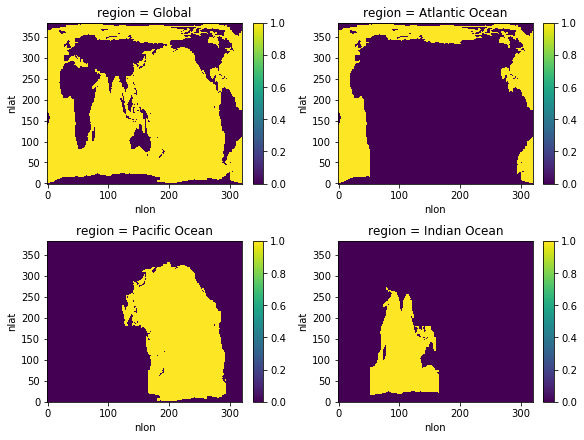

In [6]:
mask3d = pop_tools.region_mask_3d('POP_gx1v7', mask_name='Pacific-Indian-Atlantic')
basins = mask3d.region
nregion = len(mask3d.region)
ncol = int(np.sqrt(nregion))
nrow = int(nregion/ncol) + min(1, nregion%ncol)

fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),
                       constrained_layout=True)

for i, region in enumerate(mask3d.region.values):
    plt.axes(ax.ravel()[i])
    mask3d.sel(region=region).plot()

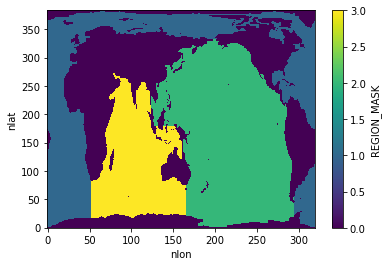

In [7]:
mask2d = xr.full_like(mask3d.isel(region=0), fill_value=0, dtype=np.int32)
for i in range(1, nregion): # skip first index because "za" puts the global field in there
    mask2d = xr.where(mask3d.isel(region=i)==1, i, mask2d)
mask2d.name = 'REGION_MASK'
mask2d.plot()

In [8]:
%%time
force_units = 'mmol/m^3'
force_units_pretty = 'mmol m$^{-3}$'

kwargs = dict(grid='POP_gx1v7', region_mask=mask2d)

ds_zonal_mean = xr.Dataset()
for var in nutrients:
    ds_tmp = utils.zonal_mean_via_fortran(ds[var], var, **kwargs)
    ds_tmp[var].attrs['units'] = force_units_pretty
    
    ds_zonal_mean[var] = ds_tmp[var]
    ds_tmp = utils.zonal_mean_via_fortran(ds_obs[var], var, **kwargs)
    
    ds_tmp[var].data = (ds_tmp[var].data * UnitRegistry[ds_tmp[var].attrs['units']] 
                        * (1026.*UnitRegistry['kg/m^3'])).to(force_units).magnitude    
    ds_tmp[var].attrs['units'] = force_units_pretty
    ds_tmp[var].attrs['long_name'] = var
    ds_zonal_mean[f'{var}_obs'] = ds_tmp[var]

ds_zonal_mean.z_t.data = (ds_zonal_mean.z_t.data * UnitRegistry[ds_zonal_mean.z_t.units]).to('m').magnitude
ds_zonal_mean.z_t.attrs['units'] = 'm'
ds_zonal_mean.info()    

za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
xarray.Dataset {
dimensions:
	basins = 4 ;
	lat_t = 394 ;
	z_t = 60 ;

variables:
	float64 z_t(z_t) ;
		z_t:long_name = depth from surface to midpoint of layer ;
		z_t:units = m ;
		z_t:positive = down ;
	float32 lat_t(lat_t) ;
		lat_t:long_name = Latitude Cell Centers ;
		lat_t:units = degrees_north ;
		lat_t:edges = lat_t_edges ;
	float32 NO3(basins, z_t, lat_t) ;
		NO3:long_name = Dissolved Inorganic Nitrate ;
		NO3:units = mmol m$^{-3}$ ;
		NO3:grid_loc = 3111 ;
		NO3:cell_methods = time: mean ;
	float32 NO3_obs(basins, z_t, lat_t) ;
		NO3_obs:wgtFile = /glade/work/mlevy/regrid/weight_files/latlon_1x1_180W_to_POP_gx1v7_bilinear_20180530.nc ;
		NO3_obs:src_file_varname = n_an ;
		NO3_obs:src_file = /glade/work/mlevy/woa2018/1x1d/

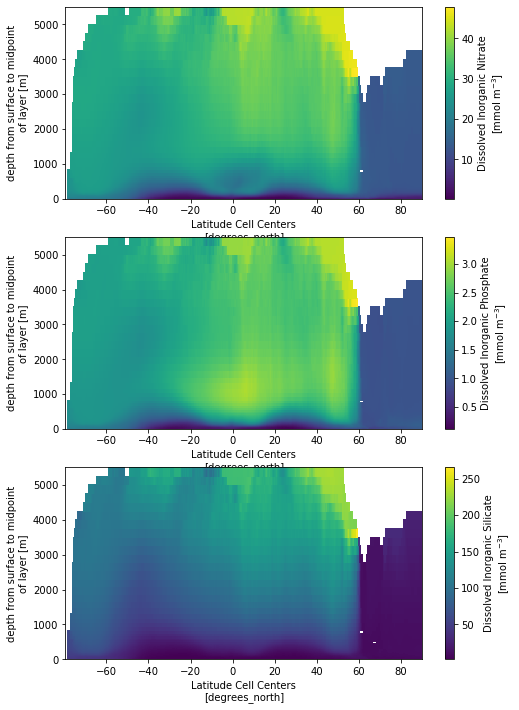

In [9]:
plt.figure(figsize=(8, 12))
plt.subplot(3, 1, 1)
ds_zonal_mean.NO3.isel(basins=0).plot()
plt.subplot(3, 1, 2)
ds_zonal_mean.PO4.isel(basins=0).plot()
plt.subplot(3, 1, 3)
ds_zonal_mean.SiO3.isel(basins=0).plot();

In [10]:
%%time
force_units = 'mmol/m^3'
force_units_pretty = 'mmol m$^{-3}$'

glb_avg = xr.Dataset()
for var in nutrients:
    print(f'Computing weighted mean of {var} for CESM output...')
    da_tmp = esmlab.weighted_mean(ds[var][var], weights=ds[var].TAREA, dim=['nlat', 'nlon']).compute()
    glb_avg[var] = da_tmp
    glb_avg[var].attrs['units'] = force_units_pretty
    glb_avg[var].attrs['long_name'] = var
    
    print(f'Computing weighted mean of {var} for WOA data...')
    da_tmp = esmlab.weighted_mean(ds_obs[var][var], weights=ds_obs[var].TAREA, dim=['nlat', 'nlon']).compute()
    glb_avg[f'{var}_obs'] = da_tmp
    glb_avg[f'{var}_obs'].data = ((da_tmp.data * UnitRegistry[ds_obs[var][var].attrs['units']]) * (1026.*UnitRegistry['kg/m^3'])).to('mmol/m^3').magnitude
    glb_avg[f'{var}_obs'].attrs['units'] = force_units_pretty
    glb_avg[f'{var}_obs'].attrs['long_name'] = var

glb_avg = glb_avg.drop('time')
glb_avg.z_t.data = (glb_avg.z_t.data * UnitRegistry[glb_avg.z_t.units]).to('m').magnitude
glb_avg.z_t.attrs['units'] = 'm'    
glb_avg.z_t.attrs['long_name'] = 'Depth'    
glb_avg.info()    

Computing weighted mean of NO3 for CESM output...
Computing weighted mean of NO3 for WOA data...
Computing weighted mean of PO4 for CESM output...
Computing weighted mean of PO4 for WOA data...
Computing weighted mean of SiO3 for CESM output...
Computing weighted mean of SiO3 for WOA data...
xarray.Dataset {
dimensions:
	z_t = 60 ;

variables:
	float64 z_t(z_t) ;
		z_t:long_name = Depth ;
		z_t:units = m ;
		z_t:positive = down ;
	float64 NO3(z_t) ;
		NO3:long_name = NO3 ;
		NO3:units = mmol m$^{-3}$ ;
		NO3:grid_loc = 3111 ;
		NO3:cell_methods = time: mean ;
	float64 NO3_obs(z_t) ;
		NO3_obs:wgtFile = /glade/work/mlevy/regrid/weight_files/latlon_1x1_180W_to_POP_gx1v7_bilinear_20180530.nc ;
		NO3_obs:src_file_varname = n_an ;
		NO3_obs:src_file = /glade/work/mlevy/woa2018/1x1d/woa18_all_n00_01.nc ;
		NO3_obs:standard_name = moles_concentration_of_nitrate_in_sea_water ;
		NO3_obs:long_name = NO3 ;
		NO3_obs:cell_methods = area: mean depth: mean time: mean within years time: mean over ye

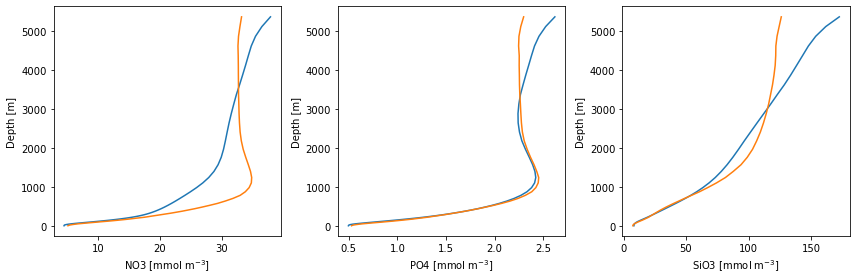

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
glb_avg.NO3.plot(y='z_t')
glb_avg.NO3_obs.plot(y='z_t')

plt.subplot(1, 3, 2)
glb_avg.PO4.plot(y='z_t')
glb_avg.PO4_obs.plot(y='z_t')

plt.subplot(1, 3, 3)
glb_avg.SiO3.plot(y='z_t');
glb_avg.SiO3_obs.plot(y='z_t');

plt.tight_layout()

In [12]:
import importlib
importlib.reload(utils)
dso_map = {
    'data/nutrients-surface-maps.zarr': ds_surf_plot, 
    'data/nutrients-zonal-section.zarr': ds_zonal_mean,  
    'data/nutrients-global-profile.zarr': glb_avg,      
}
for file_out, dso in dso_map.items():
    utils.write_ds_out(dso, file_out)

------------------------------
Writing /glade/u/home/mclong/p/cesm2-marbl/notebooks/data/nutrients-surface-maps.zarr
xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 321 ;

variables:
	float64 TLAT(nlat, nlon) ;
	float64 TLONG(nlat, nlon) ;
	float32 NO3(nlat, nlon) ;
		NO3:units = mmol m$^{-3}$ ;
		NO3:long_name = NO3 ;
	float32 NO3_obs(nlat, nlon) ;
		NO3_obs:units = mmol m$^{-3}$ ;
		NO3_obs:long_name = NO3 ;
	float32 PO4(nlat, nlon) ;
		PO4:units = mmol m$^{-3}$ ;
		PO4:long_name = PO4 ;
	float32 PO4_obs(nlat, nlon) ;
		PO4_obs:units = mmol m$^{-3}$ ;
		PO4_obs:long_name = PO4 ;
	float32 SiO3(nlat, nlon) ;
		SiO3:units = mmol m$^{-3}$ ;
		SiO3:long_name = SiO3 ;
	float32 SiO3_obs(nlat, nlon) ;
		SiO3_obs:units = mmol m$^{-3}$ ;
		SiO3_obs:long_name = SiO3 ;

// global attributes:
}
------------------------------
Writing /glade/u/home/mclong/p/cesm2-marbl/notebooks/data/nutrients-zonal-section.zarr
xarray.Dataset {
dimensions:
	basins = 4 ;
	lat_t = 394 ;
	z_t = 60 ;

variables:
	f